# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

- The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Initialization

`libraries`

In [389]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [390]:
import pandas as pd
import numpy as np
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import randint as sp_randint
from numpy import unique

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import plotly.express as px
# px.defaults.template = "ggplot2"
from plotly.subplots import make_subplots
import plotly.graph_objects as go

`data import`

In [391]:
try:
    data = pd.read_csv('/kaggle/input/taxi-time-series/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/Users/dani/Data Science/TripleTen Projects/Project Data/Time Series/taxi.csv', index_col=[0], parse_dates=[0])


`data review`

In [392]:
data.shape

(26496, 1)

In [393]:
data.info() # no perceived NaN values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [394]:
data.isna().sum()

num_orders    0
dtype: int64

In [395]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [396]:
display(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


`data sorting`

In [397]:
data.sort_index(inplace=True)

`data resampling - hourly`

In [398]:
## rs = resampled

data = data.resample('1H').sum()

df_2 = data.copy()
monthly_data = df_2.resample('M').sum()

df_3 = data.copy()
daily_data = df_3.resample('D').sum()


In [399]:
display(data)
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Analysis

`data plotting`

In [400]:
fig = px.line(data,
             title="Number of Airport Taxi Orders<br><sup>6 month horizon</sup>",
              labels={
                     "datetime": "Month",
                     "value": "Taxi Orders"
                 })

fig.update_layout(showlegend=False, autosize=False)

fig.show()

`average number of orders per month`

In [401]:
grouped_data_mean = data.groupby(by=[data.index.month]).mean()
display(grouped_data_mean)

grouped_data_sum = data.groupby(by=[data.index.month]).sum()


,num_orders
datetime,
3,57.483871
4,63.804167
5,73.682796
6,83.202778
7,100.006720
8,127.651882


In [402]:
fig = px.bar(grouped_data_mean, 
              title="Average Taxi Orders per Month",
              labels={
                     "datetime": "Month (#)",
                     "value": "Average Taxi Orders"
                 }, text_auto=True)

fig.update_layout(showlegend=False, autosize=False)
fig.update_layout(yaxis= dict(title='Taxi Orders', showticklabels=False),
                  xaxis=dict(title='Month',
                  # gridcolor='grey',
                  #tickmode= 'array',
                  #tickmode= 'linear',
                  #tick0= 3,
                  #dtick=2,
                  tickvals= [3, 4, 5, 6, 7, 8],
                  ticktext = ["March", "April", "May", "June", "July", "August"]))

fig.show()

**`Findings`**

Taxi Orders - Orders per Month
- Total and average taxi order increases as we head into the Fall, August volume is double of that of March possibly indicating (without looking at any additional data or series horizon) a strong relationship between taxi orders and the holiday season (e.g., summer vacations).

### Trends and Seasonality

In [403]:
decomposed = seasonal_decompose(data, extrapolate_trend='freq')

trend_data = decomposed.trend
seasonal_data = decomposed.seasonal
residual_data = decomposed.resid

In [404]:
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.02)

fig.append_trace(go.Scatter(
    x = trend_data.index, y= trend_data
), row=1, col=1)

fig.append_trace(go.Scatter(
    x = seasonal_data.index, y= seasonal_data
), row=2, col=1) ## assuming this is shown this way given the short time frame (not enough for seasonality)

fig.append_trace(go.Scatter(
    x = residual_data.index, y= residual_data
), row=3, col=1)


fig.update_layout(height=800, width=1000, title_text="Trends and Seasonality<br><sup>Hourly basis</sup>")
fig.update_yaxes(title_text="Trends", row=1, col=1)
fig.update_yaxes(title_text="Seasonality <br><sup>no seasonality due to short horizon</sup>", row=2, col=1)
fig.update_yaxes(title_text="Residuals", row=3, col=1)

fig.update_layout(showlegend=False)


fig.show()

**`Findings`**

Taxi Orders - Hourly Trends and Seasonality
- From our 2018 dataset, which was resampled to an hourly frequency, we see an upwards trend in taxi orders as we head into the later months of the year. While we see no seasonality due to the short series horizon we are given, if the data were to be similar each year then we could safely assume there is/will be predictability with airport taxi orders as orders contract during the winter/spring and expand the following seasons (summer/fall).

In [405]:
decomposed_resampled = seasonal_decompose(monthly_data, extrapolate_trend='freq', period=2)
# .asfreq('MS')

sliced_trend_data = decomposed_resampled.trend
sliced_seasonal_data = decomposed_resampled.seasonal
sliced_residual_data = decomposed_resampled.resid

fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.02)

fig.append_trace(go.Scatter(
    x = sliced_trend_data.index, y= sliced_trend_data #['2018-05':'2018-08']
), row=1, col=1)

fig.append_trace(go.Scatter(
    x = sliced_seasonal_data.index, y= sliced_seasonal_data #['2018-05':'2018-08']
), row=2, col=1) ## assuming this is shown this way given the short time frame (not enough for seasonality)

fig.append_trace(go.Scatter(
    x = sliced_residual_data.index, y= sliced_residual_data #['2018-05':'2018-08']
), row=3, col=1)


fig.update_layout(height=800, width=1000, title_text="Monthly Trends and Seasonality<br><sup>Monthly basis</sup>")
fig.update_yaxes(title_text="Trends", row=1, col=1)
fig.update_yaxes(title_text="Seasonality", row=2, col=1)
fig.update_yaxes(title_text="Residuals", row=3, col=1)

fig.update_layout(showlegend=False)


fig.show()

`data validation - decomposed data vs original dataset`

In [406]:
print(decomposed.trend[1:6] + decomposed.seasonal[1:6] + decomposed.resid[1:6])
print()
print(data.num_orders[1:6])

datetime
2018-03-01 01:00:00    85.0
2018-03-01 02:00:00    71.0
2018-03-01 03:00:00    66.0
2018-03-01 04:00:00    43.0
2018-03-01 05:00:00     6.0
Freq: H, dtype: float64

datetime
2018-03-01 01:00:00    85
2018-03-01 02:00:00    71
2018-03-01 03:00:00    66
2018-03-01 04:00:00    43
2018-03-01 05:00:00     6
Freq: H, Name: num_orders, dtype: int64


`time series differencing`

In [408]:
ts_difference = data - data.shift()

fig = px.line(grouped_data_sum, 
              title="Original Dataset",
              labels={
                     "datetime": "Month (#)",
                     "value": "Taxi Orders"
                 },#text_auto=True
                 )
fig.update_layout(showlegend=False, autosize=False)
fig.update_layout(yaxis= dict(title='Total Taxi Orders', showticklabels=False),
                  xaxis=dict(title='Month',
                  # gridcolor='grey',
                  #tickmode= 'array',
                  #tickmode= 'linear',
                  #tick0= 3,
                  #dtick=2,
                  tickvals= [3, 4, 5, 6, 7, 8],
                  ticktext = ["March", "April", "May", "June", "July", "August"]))

fig.show()

fig = px.line(ts_difference, 
              title="Time Series Differencing",
              labels={
                     "datetime": "Month",
                     "value": "Taxi Orders"
                 })

fig.update_layout(showlegend=False, autosize=False, yaxis= dict(title='Total Taxi Orders'))

fig.show()

`stationary series`

In [409]:
ts_difference['mean'] = ts_difference['num_orders'].rolling(15).mean()
ts_difference['std'] = ts_difference['num_orders'].rolling(15).std()

fig = px.line(ts_difference, 
              title="Orders / Mean / Standard Deviation",
              labels={
                     "datetime": "Month",
                     "value": "Taxi Orders",
                 })

fig.update_layout(legend_title_text='', autosize=False)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1,
    bgcolor="white",
    bordercolor="lightgray",
    borderwidth=1,
    ), 
)
newnames = {'num_orders':'Orders', 'mean': 'Mean', 'std': 'Standard Deviation'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                      )
                                     )

fig.show()

**`Findings`**

Taxi Orders - Sum, Mean and Standard Deviation
- Through the use of time series differencing, we create a more stationary series which which makes it easier to model and forecast. We stabilize the mean and reduce trend/seasonality. We then quickly compare to the mean and standard deviation to verify this stabilization. 


## Data Modeling

`features function`

In [346]:
def create_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

create_features(data, 11, 8)

`data splitting`

In [347]:
train, test = train_test_split(data, shuffle=False, test_size=0.091) #splitting without reshuffling
train = train.dropna()

print(train.shape)
print(test.shape)

print(test.shape[0] / train.shape[0] * 100) ## 10% of train dataset

(4003, 18)
(402, 18)
10.042468148888334


In [348]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 11:00:00 2018-08-15 05:00:00
2018-08-15 06:00:00 2018-08-31 23:00:00


In [349]:
print('Median daily taxi orders:', test['num_orders'].median())

pred_previous = test.shift()
#print(pred_previous) # shifting to find differences
pred_previous.iloc[0] = train.iloc[-1:]
#print(pred_previous.iloc[0]) # previous value
print('RMSE:', math.sqrt(mean_squared_error(test, pred_previous))) # using previous value as a baseline prediction 

Median daily taxi orders: 136.0
RMSE: 48.68549274057683


`features & targets`

In [350]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

**feature importance**

In [351]:
def feature_imp(model):
    feature_name = model.best_estimator_.feature_names_in_
    feature_importance = model.best_estimator_.feature_importances_
    return feature_name, feature_importance

`model training`

In [352]:
tscv = TimeSeriesSplit(n_splits=5)

`regression and tree models`

In [353]:
%%time
linear_model = LinearRegression()
linear_parameters = [{"positive": [True, False],
                      "fit_intercept": [True, False],
                      "n_jobs": list(range(1,250))}]

linear_clf = RandomizedSearchCV(linear_model, linear_parameters, scoring='neg_root_mean_squared_error', cv=tscv)
linear_clf.fit(features_train, target_train)
linear_prediction = linear_clf.predict(features_test)

print('Best Params:\n', linear_clf.best_params_)
print()
print('Runtime:')

Best Params:
 {'positive': False, 'n_jobs': 19, 'fit_intercept': True}

Runtime:
CPU times: user 3.94 s, sys: 201 ms, total: 4.14 s
Wall time: 1.54 s


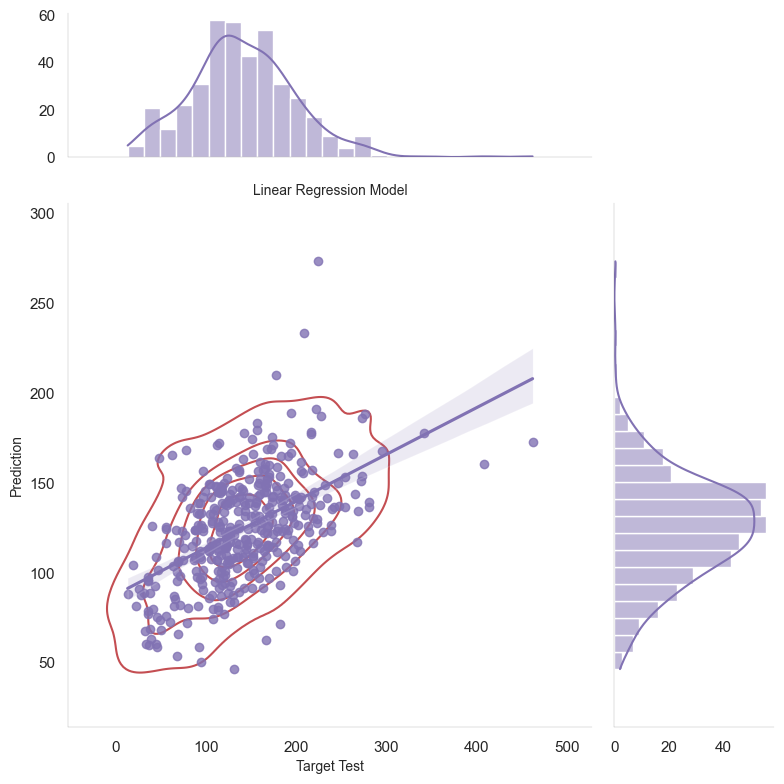

In [467]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

g = sns.jointplot(x = target_test, y = linear_prediction, kind='reg', palette='mako', height=8, ratio=3, marginal_ticks=True, color="m")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

plt.title('Linear Regression Model', fontsize=10)
g.set_axis_labels('Target Test', 'Prediction', fontsize=10)

g.fig.tight_layout()
plt.show()

In [355]:
%%time
ridge_model = Ridge(random_state=12345)
ridge_parameters = [{"alpha": list(range(0,1000)), 
                     "fit_intercept": [True, False], 
                     "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}]

ridge_clf = RandomizedSearchCV(ridge_model, ridge_parameters, scoring='neg_root_mean_squared_error', cv=tscv)
ridge_clf.fit(features_train, target_train)
ridge_prediction = ridge_clf.predict(features_test)

print('Best Params:\n', ridge_clf.best_params_)
print()
print('Runtime:')

Best Params:
 {'solver': 'lsqr', 'fit_intercept': True, 'alpha': 63}

Runtime:
CPU times: user 11.1 s, sys: 346 ms, total: 11.4 s
Wall time: 2.35 s


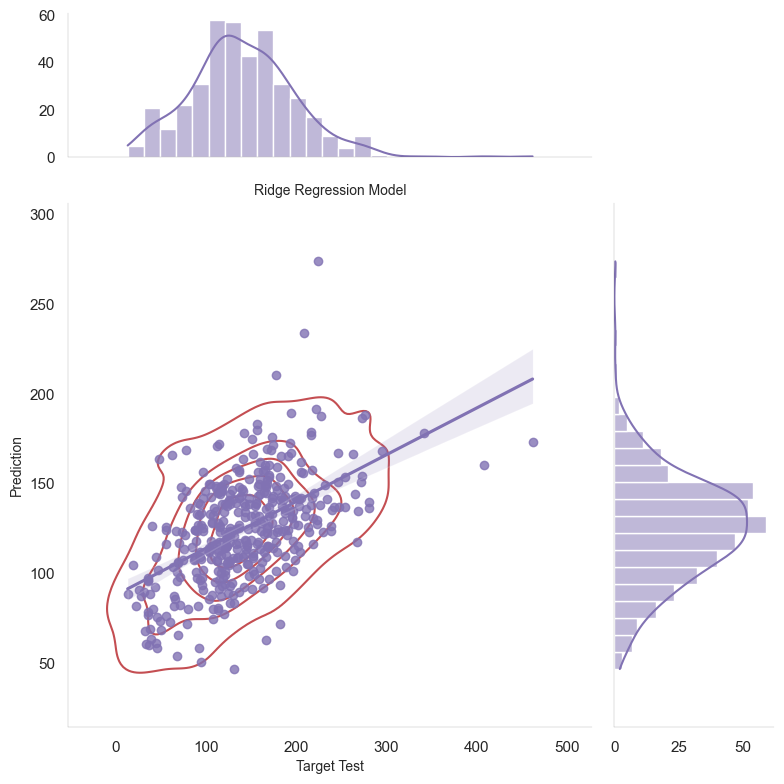

In [468]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

g = sns.jointplot(x = target_test, y = ridge_prediction, kind='reg', palette='mako', height=8, ratio=3, marginal_ticks=True, color="m")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

plt.title('Ridge Regression Model', fontsize=10)
g.set_axis_labels('Target Test', 'Prediction', fontsize=10)

ax.tick_params(color='m', labelcolor='m')
for spine in ax.spines.values():
    spine.set_edgecolor('m')

g.fig.tight_layout()
plt.show()

In [357]:
%%time
sgd_model = SGDRegressor(random_state=12345)
sgd_parameters = [{  "alpha": [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0010],
                     "fit_intercept": [True, False], 
                     "learning_rate": ['constant', 'optimal', 'invscaling', 'adaptive'],
                     "penalty": ['l2', 'l1', 'elasticnet', None],
                      "average": [True, False],
                      "shuffle": [True, False],
                      "early_stopping": [True, False],
                       "max_iter": [1000, 6000]}]

sgd_clf = RandomizedSearchCV(sgd_model, sgd_parameters, scoring='neg_root_mean_squared_error', cv=tscv)
sgd_clf.fit(features_train, target_train)
sgd_prediction = sgd_clf.predict(features_test)

print('Best Params:\n', sgd_clf.best_params_)
print()
print('Runtime:')

Best Params:
 {'shuffle': True, 'penalty': 'l2', 'max_iter': 6000, 'learning_rate': 'adaptive', 'fit_intercept': False, 'early_stopping': True, 'average': False, 'alpha': 0.0001}

Runtime:
CPU times: user 6.46 s, sys: 245 ms, total: 6.7 s
Wall time: 1.43 s


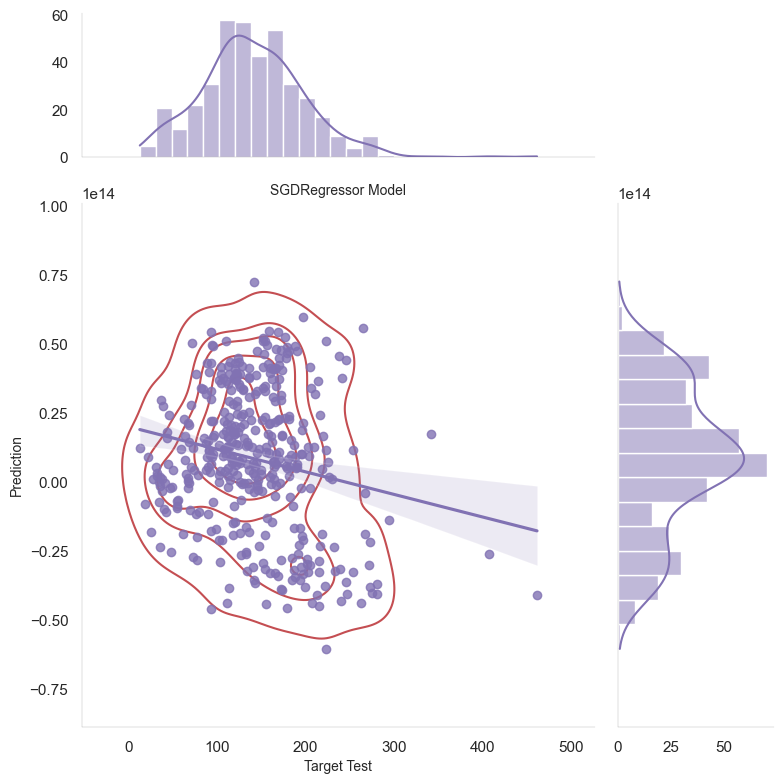

In [469]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

g = sns.jointplot(x = target_test, y = sgd_prediction, kind='reg', palette='mako', height=8, ratio=3, marginal_ticks=True, color="m")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

plt.title('SGDRegressor Model', fontsize=10)
g.set_axis_labels('Target Test', 'Prediction', fontsize=10)

g.fig.tight_layout()
plt.show()

In [359]:
%%time
tree_model = DecisionTreeRegressor(random_state=12345)
tree_parameters = [{'max_depth': [1, 10],
                    "splitter": ['best', 'random'],
                    'max_features': sp_randint(1, 12)}]

tree_clf = RandomizedSearchCV(tree_model, tree_parameters, scoring='neg_root_mean_squared_error', cv=tscv)
tree_clf.fit(features_train, target_train)
tree_prediction = tree_clf.predict(features_test)

print('Best Params:\n', tree_clf.best_params_)
print()
print('Runtime:')

Best Params:
 {'max_depth': 10, 'max_features': 11, 'splitter': 'random'}

Runtime:
CPU times: user 142 ms, sys: 10.3 ms, total: 152 ms
Wall time: 168 ms


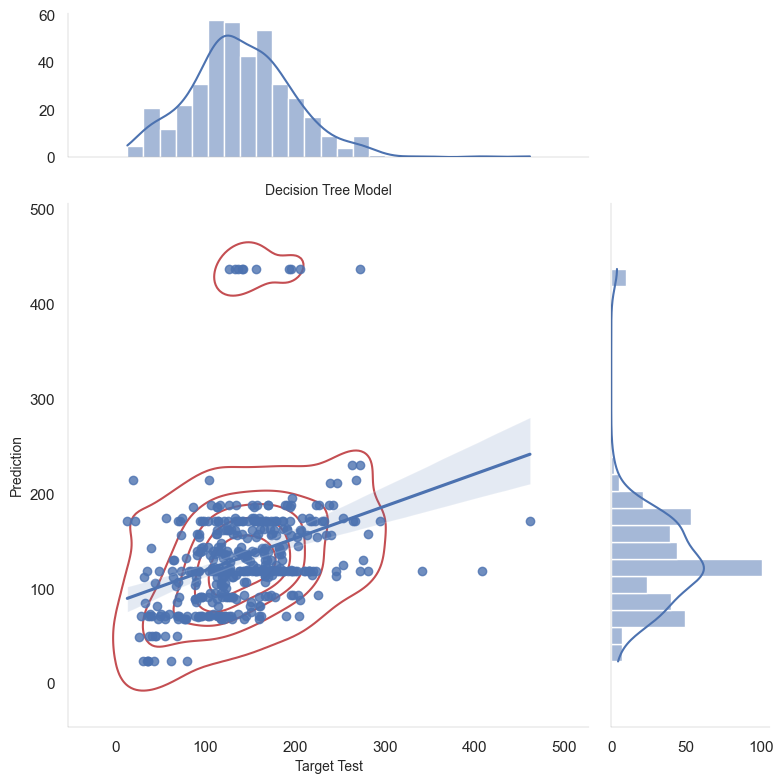

In [470]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

g = sns.jointplot(x = target_test, y = tree_prediction, kind='reg', palette='mako', height=8, ratio=3, marginal_ticks=True, color="b")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

plt.title('Decision Tree Model', fontsize=10)
g.set_axis_labels('Target Test', 'Prediction', fontsize=10)

g.fig.tight_layout()
plt.show()

In [361]:
print('Feature Importance:')
{k: v for k, v in sorted(zip(tree_clf.best_estimator_.feature_names_in_, tree_clf.best_estimator_.feature_importances_), key= lambda x: x[1], reverse=True)}

Feature Importance:


{'lag_1': 0.20968151122446096,
 'month': 0.18634355229443994,
 'hour': 0.14989255877786234,
 'rolling_mean': 0.1358353535966868,
 'lag_9': 0.04493497784269936,
 'lag_6': 0.04137370745595779,
 'lag_2': 0.03468752491263129,
 'lag_11': 0.03307068058785532,
 'lag_7': 0.02998449113725726,
 'lag_5': 0.029495359195814745,
 'lag_10': 0.02343765740668881,
 'lag_4': 0.021896268024920094,
 'lag_8': 0.018188583816409,
 'lag_3': 0.01640921569216166,
 'day': 0.014050615564348879,
 'dayofweek': 0.010717942469805803,
 'year': 0.0}

In [362]:
%%time
forest_model = RandomForestRegressor(random_state=12345)
forest_parameters = [{'max_depth': [2, 30],
                      'max_features': sp_randint(1, 20),
                     'min_samples_split': [2, 12],
                     "criterion": ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
                     "warm_start": [True, False],
                     'n_estimators': [300]}]

forest_clf = RandomizedSearchCV(forest_model, forest_parameters, scoring='neg_root_mean_squared_error', cv=tscv)
forest_clf.fit(features_train, target_train)
forest_prediction = forest_clf.predict(features_test)

print('Best Params:\n', forest_clf.best_params_)
print()
print('Runtime:')

Best Params:
 {'criterion': 'friedman_mse', 'max_depth': 30, 'max_features': 19, 'min_samples_split': 12, 'n_estimators': 300, 'warm_start': False}

Runtime:
CPU times: user 2min 14s, sys: 823 ms, total: 2min 15s
Wall time: 2min 21s


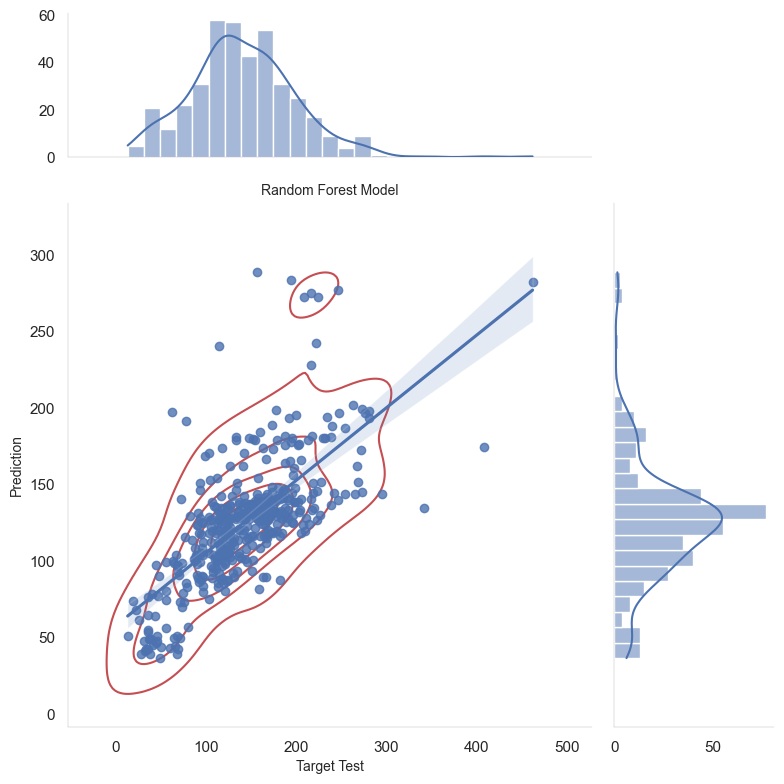

In [471]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

g = sns.jointplot(x = target_test, y = forest_prediction, kind='reg', palette='mako', height=8, ratio=3, marginal_ticks=True, color="b")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

plt.title('Random Forest Model', fontsize=10)
g.set_axis_labels('Target Test', 'Prediction', fontsize=10)

g.fig.tight_layout()
plt.show()

In [364]:
print('Feature Importance:')
{k: v for k, v in sorted(zip(forest_clf.best_estimator_.feature_names_in_, forest_clf.best_estimator_.feature_importances_), key= lambda x: x[1], reverse=True)}

Feature Importance:


{'lag_1': 0.2875668144135139,
 'hour': 0.24443408282688184,
 'rolling_mean': 0.13569582229876045,
 'lag_7': 0.036145772649394906,
 'lag_11': 0.036087789810870304,
 'month': 0.034547311061523575,
 'lag_10': 0.03414011418135814,
 'lag_2': 0.028429307593446924,
 'lag_9': 0.026835558389781102,
 'lag_8': 0.025656277399907966,
 'lag_5': 0.02308378632338043,
 'lag_6': 0.021823882462680407,
 'lag_4': 0.020948711980555555,
 'lag_3': 0.0205665136793509,
 'day': 0.012468506723476432,
 'dayofweek': 0.011569748205117155,
 'year': 0.0}

In [365]:
%%time
extra_model = ExtraTreesRegressor(random_state=12345)
extra_parameters = [{'max_depth': [2, 20],
                      'max_features': sp_randint(1, 22), 
                     'n_estimators': [150]}]

extra_clf = RandomizedSearchCV(extra_model, extra_parameters, scoring='neg_root_mean_squared_error', cv=tscv)
extra_clf.fit(features_train, target_train)
extra_prediction = extra_clf.predict(features_test)

print('Best Params:\n', extra_clf.best_params_)
print()
print('Runtime:')

Best Params:
 {'max_depth': 20, 'max_features': 20, 'n_estimators': 150}

Runtime:
CPU times: user 17.1 s, sys: 461 ms, total: 17.6 s
Wall time: 18.8 s


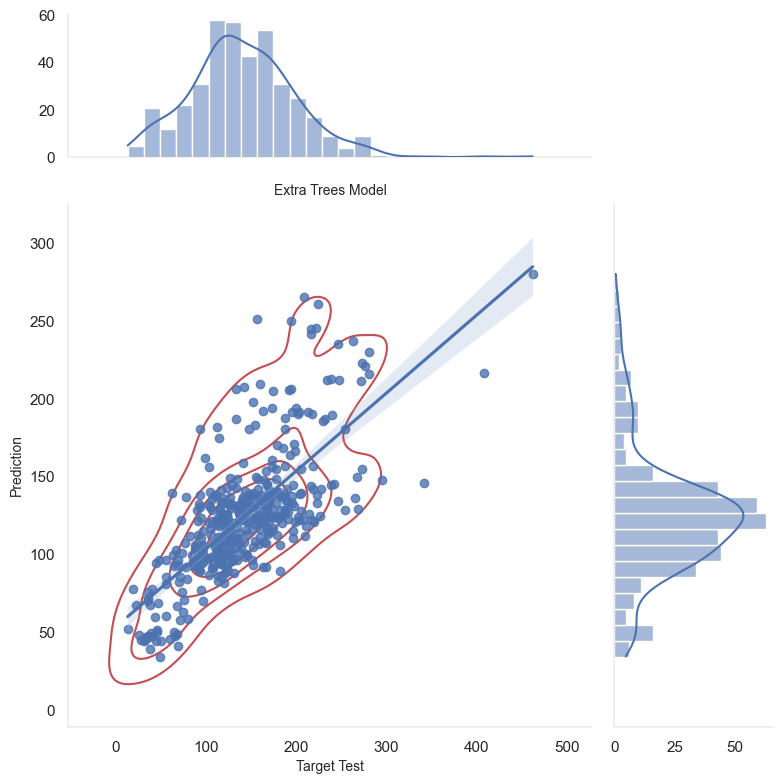

In [472]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

g = sns.jointplot(x = target_test, y = extra_prediction, kind='reg', palette='mako', height=8, ratio=3, marginal_ticks=True, color="b")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

plt.title('Extra Trees Model', fontsize=10)
g.set_axis_labels('Target Test', 'Prediction', fontsize=10)

g.fig.tight_layout()
plt.show()

In [378]:
print('Feature Importance:')
{k: v for k, v in sorted(zip(extra_clf.best_estimator_.feature_names_in_, extra_clf.best_estimator_.feature_importances_), key= lambda x: x[1], reverse=True)}

Feature Importance:


{'hour': 0.22976290380546685,
 'lag_1': 0.18247938235348762,
 'month': 0.15538634644475963,
 'rolling_mean': 0.060019609813393715,
 'lag_7': 0.038608898897048924,
 'lag_2': 0.03777453996284744,
 'lag_10': 0.03391221488493349,
 'lag_3': 0.033026510655584033,
 'lag_11': 0.031229460325348887,
 'lag_6': 0.030289239467505003,
 'lag_5': 0.030003052424896436,
 'lag_8': 0.02938774213074865,
 'dayofweek': 0.028174502219558348,
 'lag_9': 0.02741195564441247,
 'lag_4': 0.026988960149802666,
 'day': 0.025544680820205858,
 'year': 0.0}

`gradient boosting models`

In [379]:
%%time

lgb_reg = lgb.LGBMRegressor(random_state=12345)
# **lgb_parameters

lgb_reg_parameters = {  
'learning_rate': [0.01, 0.05, 0.08, 0.09, 0.1, 0.11, 0.15, 0.2]
, 'boosting_type': ['gbdt', 'dart']
, 'max_depth': [1, 20]
, 'num_leaves': [31, 175]
, 'n_estimators': [20, 300]
, 'class_weight': ['balanced', None]
, 'n_jobs': [1, 30]
, 'importance_type': ['split', 'gain']
, 'min_child_samples': [20,55]
}

lgb_clf = RandomizedSearchCV(lgb_reg, lgb_reg_parameters, scoring='neg_root_mean_squared_error', cv=tscv)
lgb_clf.fit(features_train, target_train)
lgb_prediction = lgb_clf.predict(features_test)

print('')
print('Runtime:')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1401
[LightGBM] [Info] Number of data points in the train set: 668, number of used features: 15
[LightGBM] [Info] Start training from score 57.148204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad sinc

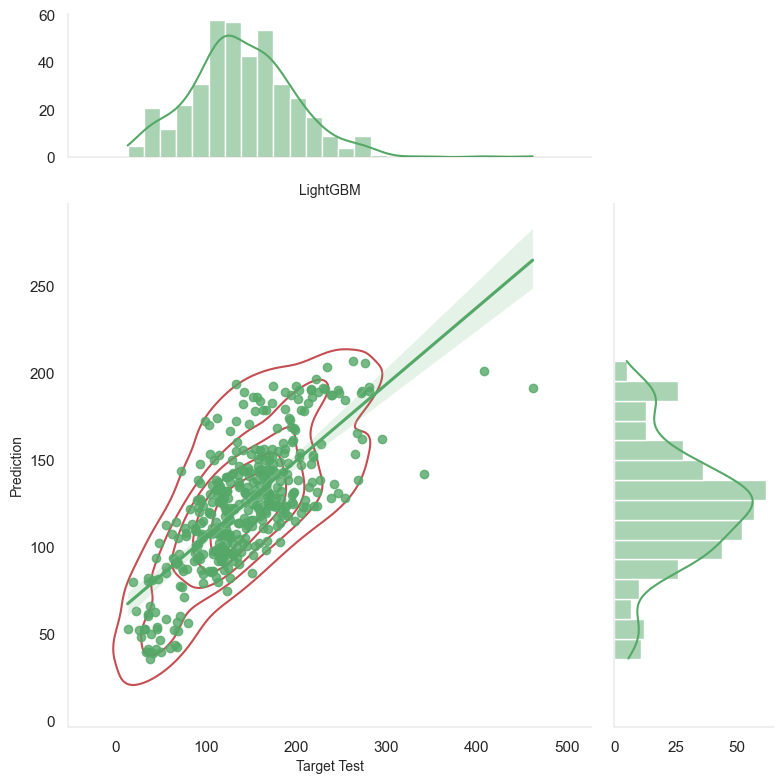

In [473]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

g = sns.jointplot(x = target_test, y = lgb_prediction, kind='reg', palette='mako', height=8, ratio=3, marginal_ticks=True, color="g")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

plt.title('LightGBM', fontsize=10)
g.set_axis_labels('Target Test', 'Prediction', fontsize=10)

g.fig.tight_layout()
plt.show()

In [381]:
boost = lgb_reg.fit(features_train, target_train).booster_
# print('Feature names',boost.feature_name())

print('Feature Importance:')
{k: v for k, v in sorted(zip(boost.feature_name(), lgb_clf.best_estimator_.feature_importances_), key= lambda x: x[1], reverse=True)}

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2426
[LightGBM] [Info] Number of data points in the train set: 4003, number of used features: 16
[LightGBM] [Info] Start training from score 78.801899
Feature Importance:


{'hour': 15855627.564971924,
 'lag_1': 15269739.155578613,
 'rolling_mean': 6204668.132064819,
 'month': 2946957.987991333,
 'lag_11': 1857951.1889190674,
 'lag_7': 1807177.7387695312,
 'lag_10': 1709543.6399383545,
 'lag_2': 1647321.01512146,
 'lag_9': 1223202.9596252441,
 'lag_3': 1221501.1853027344,
 'lag_5': 1066377.7414855957,
 'lag_6': 1017585.292098999,
 'dayofweek': 991177.2432098389,
 'lag_4': 948943.9563598633,
 'lag_8': 938911.0266723633,
 'day': 590134.8897705078,
 'year': 0.0}

In [382]:
%%time 
xgb_param = {"booster": ["gblinear", 'dart', 'gbtree'],
             "validate_parameters": [True, False],
             "max_depth": [1, 10],
             "subsample": [0.5, 1],
             "sampling_method": ["uniform", "gradient_based", "subsample"],
             "tree_method": ["auto", "exact", "approx"],
             "max_leaves": [2, 10],
             "feature_selector": ["shuffle", "cyclic", "random"],
             "updater": ["coord_descent", "shotgun"],
             "eta": [0.1, 0.2, 0.3]
        }


xgb_reg = XGBRegressor(random_state=12345)
xgb_clf = RandomizedSearchCV(xgb_reg, xgb_param, scoring='neg_root_mean_squared_error', cv=tscv)
xgb_clf.fit(features_train, target_train)
xgb_prediction = xgb_clf.predict(features_test)

print('')
print('Runtime:')


Runtime:
CPU times: user 4.31 s, sys: 1.47 s, total: 5.77 s
Wall time: 902 ms


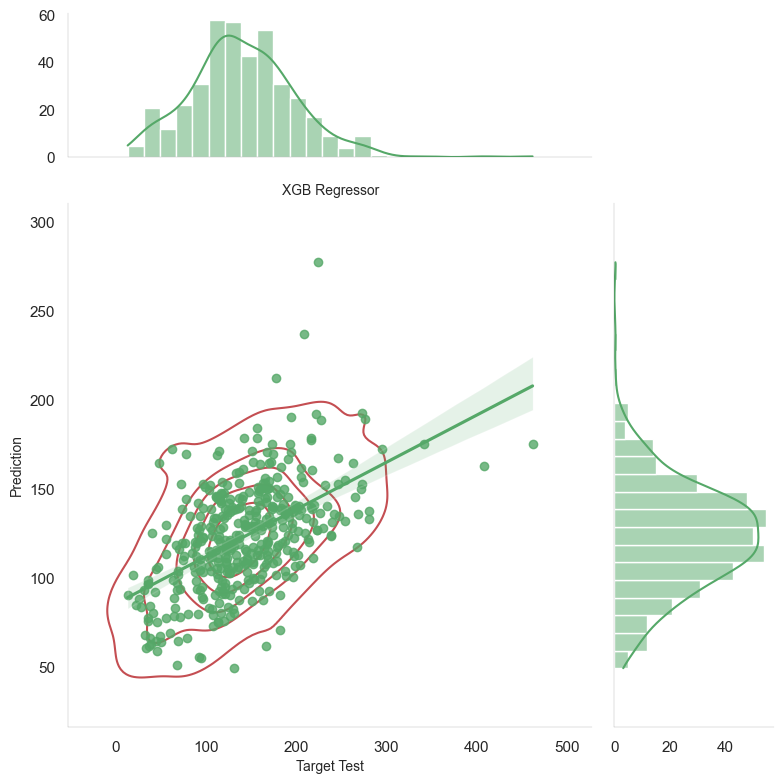

In [474]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

g = sns.jointplot(x = target_test, y = xgb_prediction, kind='reg', palette='mako', height=8, ratio=3, marginal_ticks=True, color="g")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

plt.title('XGB Regressor', fontsize=10)
g.set_axis_labels('Target Test', 'Prediction', fontsize=10)

g.fig.tight_layout()
plt.show()

### Model Comparison

In [384]:
def best_score(model_name, model_type):
    print(f'Best Score for the {model_name} model:\n', model_type.best_score_)

In [385]:
best_score('LinearRegression', linear_clf)
print()
best_score('RidgeRegression', ridge_clf)
print()
best_score('TreeRegressor', tree_clf)
print() 
best_score('SGDRegressor', sgd_clf)
print()
best_score('RandomForestRegressor', forest_clf)
print()
best_score('ExtraRegressor', extra_clf)
print()
best_score('LGBRegressor', lgb_clf)
print()
best_score('XGBRegressor', xgb_clf)

Best Score for the LinearRegression model:
 -31.557819887270284

Best Score for the RidgeRegression model:
 -31.593673930056333

Best Score for the TreeRegressor model:
 -34.0548921668631

Best Score for the SGDRegressor model:
 -30928278025760.125

Best Score for the RandomForestRegressor model:
 -25.556320436121275

Best Score for the ExtraRegressor model:
 -24.79419342763454

Best Score for the LGBRegressor model:
 -25.58104035158474

Best Score for the XGBRegressor model:
 -32.349128784497175


**`Findings`**

Model Training - Scoring comparison
- Through the use of RandomizedSearchCV, we compared scores for all of our regression models including those leveraging boosting methods using `scoring='neg_root_mean_squared_error'`. Those closest to zero were the Extra Tree Regressor as well as the Light Gradient Regressor. 

## Final Evaluation

In [386]:
def eval_regressor(model, y_true, y_pred):
    
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    print(f'{model} RMSE: {rmse:.2f}')

eval_regressor('LGB Regressor', target_test, lgb_prediction) # final evaluation on test set

LGB Regressor RMSE: 44.74


## Conclusion



**`Data`**
- Based on the available data provided by Sweet Lift, we see increases in the number of taxi orders (per hour) largely starting from the summer towards the fall seasons. This can be due to 1) holidays, 2) decreases in airline prices (allowing for more people to travel), 3) weather (rain/cold leading to more taxi orders for example). Average taxi orders double from March to August of 2018.


- While further seasonality analysis would be helpful, due to the limited time horizon given to us there isn't much to decipher from this aside from making very general assumptions (like increases due to holidays).



- The analysis would benefit, in my opinion, from 1) a much wider scope, 2) airline price information, 3) weather information, 4) taxi price data (as well as competitor pricing), 5) any marketing/promotion information (by Sweet Lift), 6) booking information (calling vs app usage), 7) vehicle (taxi) information (model, type, etc...). 

**`Models`**
- Model training begain with feature creation, adding features to the data set based on `datetime` like: year, month, day, lag and rolling mean. This was then split with a test size target of 10% of the training set, along with all `NaN` values being dropped from the training set.


- Once complete, we ran simple forecasting (checking the time horizon) and tested for accuracy to make sure there weren't any issues as we dive deeper into model training. 


- Using `RandomizedSearchCV` we trained various regression models and tuned their hyperparameters. Various of these models weren't providing the desired training results (see SGDRegressor for example) or were becoming overfitted. Gradient Boosting methods were then deployed as the desired RMSE result was hard to achieve.


- Once we honed in on an optimal selection, **being the Light Gradient Boosting Method**, we performed evaluations on the test dataset. While LGBM training takes longer and it's more sensitive to overfitting, this was the selection due to the overall advantages/flexibility of LGBM parameter tuning (e.g., boosting) and it should be a good starting base model if we were to introduce more features/pattern complexity (like some of the ones mentioned above).


- Evaluating the test dataset, we achieved an RMSE value of ~44. This was partially achieved by tuning the `max_lag` and `rolling_mean` parameters as we were creating the features. These parameters seem to have played a significant role (compared to some of the hyperparameters) in getting the RMSE near the target value.
